In [1]:

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, concatenate, add
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop
from keras.applications import InceptionV3
from keras.utils.data_utils import get_file
import random
import os
from keras import regularizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore", UserWarning)
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 150
image_height = 150

img_rows =  224
img_cols =  224
image_size = (image_width, image_height)

data_datagen = ImageDataGenerator(rescale=1.0/255,  validation_split=0.20, featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False)

train_generator = data_datagen.flow_from_directory(
        '../input/simpsons-dataset/simpsons_dataset/simpsons_dataset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='training')

validation_generator = data_datagen.flow_from_directory(
        '../input/simpsons-dataset/simpsons_dataset/simpsons_dataset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',
         subset='validation', shuffle = False)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
       '../input/dataset-simpsons-test/kaggle_simpson_testset/',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='categorical',shuffle = False)

Found 11054 images belonging to 10 classes.
Found 2757 images belonging to 10 classes.
Found 456 images belonging to 10 classes.


In [3]:
def create_model():
    inception = InceptionV3(include_top=False, input_shape=(150, 150, 3))
    
    model = Sequential()
    model.add(inception)
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(Dense(10, activation='softmax'))   
    model.summary()
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    #rmsprop = RMSprop(lr=1e-3, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
    return model
    

In [4]:
model = create_model()

87916544/87910968 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 26,532,394
Trainable params: 26,493,866
Non-trainable params: 3

In [5]:
n_train = 11054
batch_size = 32
n_valid = 2757
history = model.fit_generator(
       train_generator,
       steps_per_epoch=n_train//batch_size,
       epochs=10,
       validation_data=validation_generator,
       validation_steps=n_valid//batch_size)

Epoch 1/10
345/345 [==============================] - 126s 366ms/step - loss: 37.1583 - acc: 0.5379 - val_loss: 29.1492 - val_acc: 0.7900
Epoch 2/10
345/345 [==============================] - 104s 300ms/step - loss: 22.9346 - acc: 0.8217 - val_loss: 17.4345 - val_acc: 0.8060
Epoch 3/10
345/345 [==============================] - 104s 301ms/step - loss: 12.6691 - acc: 0.8854 - val_loss: 8.6973 - val_acc: 0.9011
Epoch 4/10
345/345 [==============================] - 103s 297ms/step - loss: 5.9335 - acc: 0.9022 - val_loss: 3.8371 - val_acc: 0.8459
Epoch 5/10
345/345 [==============================] - 102s 296ms/step - loss: 2.3748 - acc: 0.9257 - val_loss: 1.6780 - val_acc: 0.8996
Epoch 6/10
345/345 [==============================] - 103s 297ms/step - loss: 1.3528 - acc: 0.9312 - val_loss: 1.2437 - val_acc: 0.9346
Epoch 7/10
345/345 [==============================] - 102s 297ms/step - loss: 1.1554 - acc: 0.9370 - val_loss: 1.2174 - val_acc: 0.9216
Epoch 8/10
345/345 [=======================

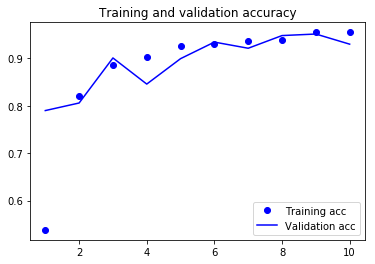

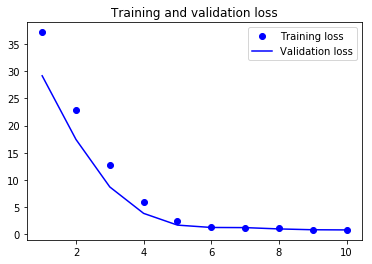

In [6]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best');

In [7]:
n_test = 456
Y_pred = model.predict_generator(test_generator, n_test//16+1)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)



In [8]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)

Confusion Matrix


In [9]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()

Confusion matrix, without normalization
[[50  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  0  1  0  0  0  0]
 [ 0  0  0 42  0  0  0  0  0  0]
 [ 0  0  0  0 45  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  1  0  0  0 48  0  0  0]
 [ 0  1  0  0  0  0  0 43  0  0]
 [ 0  0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0  0 44]]


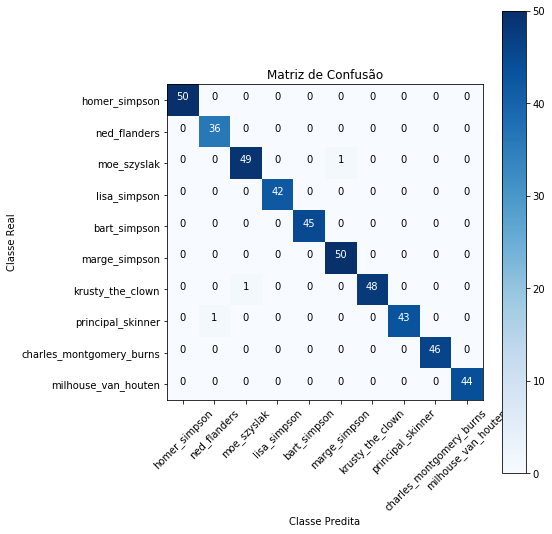

In [10]:
nomes_classes=['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson','bart_simpson',
         'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']
plot_confusion_matrix(cm, classes=nomes_classes,
                      title='Matriz de Confusão')

In [11]:

target_names=['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 
                 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 
                 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']
print (classification_report (test_generator.classes, y_pred, target_names = target_names))

                          precision    recall  f1-score   support

           homer_simpson       1.00      1.00      1.00        50
            ned_flanders       0.97      1.00      0.99        36
             moe_szyslak       0.98      0.98      0.98        50
            lisa_simpson       1.00      1.00      1.00        42
            bart_simpson       1.00      1.00      1.00        45
           marge_simpson       0.98      1.00      0.99        50
        krusty_the_clown       1.00      0.98      0.99        49
       principal_skinner       1.00      0.98      0.99        44
charles_montgomery_burns       1.00      1.00      1.00        46
     milhouse_van_houten       1.00      1.00      1.00        44

             avg / total       0.99      0.99      0.99       456

